Датасет содержит информацию о баскетбольных матчах, включая данные о командах, игроках, их действиях на площадке и результатах бросков. Каждая строка представляет собой запись о конкретном броске или действии игрока во время матча.

Задача заключается в анализе данных о баскетбольных матчах с целью предсказания успешности броска (Made Shot или Missed Shot) на основе различных характеристик, таких как зона броска, расстояние до корзины, тип броска и т.д.

SEASON_1: Сезон (например, 2024).

SEASON_2: Сезон в формате "2023-24".

TEAM_ID: Уникальный идентификатор команды.

TEAM_NAME: Название команды (например, Washington Wizards).

PLAYER_ID: Уникальный идентификатор игрока.

PLAYER_NAME: Имя игрока (например, Jordan Poole).

POSITION_GROUP: Группа позиций игрока (например, G — Guard).

POSITION: Позиция игрока (например, SG — Shooting Guard).

GAME_DATE: Дата игры (например, 11-03-2023).

GAME_ID: Уникальный идентификатор игры.

HOME_TEAM: Команда, играющая дома (например, MIA — Miami Heat).

AWAY_TEAM: Команда, играющая на выезде (например, WAS — Washington Wizards).

EVENT_TYPE: Тип события (например, Missed Shot или Made Shot).

SHOT_MADE: Был ли бросок успешным (TRUE или FALSE).

ACTION_TYPE: Тип действия (например, Jump Shot, Driving Layup Shot).

SHOT_TYPE: Тип броска (например, 2PT Field Goal, 3PT Field Goal).

BASIC_ZONE: Основная зона на площадке, откуда был выполнен бросок (например, In The Paint (Non-RA)).

ZONE_NAME: Название зоны (например, Center).

ZONE_ABB: Сокращение зоны (например, C — Center).

ZONE_RANGE: Диапазон расстояния броска (например, 8-16 ft.).

LOC_X: Координата X на площадке, откуда был выполнен бросок.

LOC_Y: Координата Y на площадке, откуда был выполнен бросок.

SHOT_DISTANCE: Расстояние до корзины в футах.

QUARTER: Квартал игры (1, 2, 3, 4).

MINS_LEFT: Минуты, оставшиеся до конца квартала.

SECS_LEFT: Секунды, оставшиеся до конца квартала.

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('/kaggle/input/ml-nba/ml_nba/NBA_2024_Shots.csv')

sample_df = df.sample(n=30000)

sample_df.to_csv('sample_file.csv', index=False)


Исключение ненужных данных

In [3]:
import pandas as pd

data = pd.read_csv('/kaggle/working/sample_file.csv')
data = data.drop('EVENT_TYPE', axis=1)
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [4]:
columns_to_drop = ['SEASON_1', 'SEASON_2', 'TEAM_ID', 'TEAM_NAME', 'PLAYER_ID', 'PLAYER_NAME', 'GAME_DATE', 'GAME_ID','POSITION_GROUP']
data_cleaned = data.drop(columns=columns_to_drop)

print(data_cleaned.columns)

Index(['POSITION', 'HOME_TEAM', 'AWAY_TEAM', 'SHOT_MADE', 'ACTION_TYPE',
       'SHOT_TYPE', 'BASIC_ZONE', 'ZONE_NAME', 'ZONE_ABB', 'ZONE_RANGE',
       'LOC_X', 'LOC_Y', 'SHOT_DISTANCE', 'QUARTER', 'MINS_LEFT', 'SECS_LEFT'],
      dtype='object')


Обработка выбросов

In [5]:
import numpy as np

def detect_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return column[(column < lower_bound) | (column > upper_bound)]

numerical_columns = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_columns:
    outliers = detect_outliers(data_cleaned[col])
    print(f"Выбросы в столбце {col}: {len(outliers)}")

Выбросы в столбце LOC_X: 5078
Выбросы в столбце LOC_Y: 43
Выбросы в столбце SHOT_DISTANCE: 12
Выбросы в столбце QUARTER: 0
Выбросы в столбце MINS_LEFT: 0
Выбросы в столбце SECS_LEFT: 0


In [6]:
for col in numerical_columns:
    Q1 = data_cleaned[col].quantile(0.25)
    Q3 = data_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data_cleaned = data_cleaned[(data_cleaned[col] >= lower_bound) & (data_cleaned[col] <= upper_bound)]

print(f"Размер данных после удаления выбросов: {data_cleaned.shape}")

Размер данных после удаления выбросов: (24899, 16)


Основные статистики

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

print(data.describe())

       SEASON_1       TEAM_ID     PLAYER_ID       GAME_ID         LOC_X  \
count   30000.0  3.000000e+04  3.000000e+04  3.000000e+04  30000.000000   
mean     2024.0  1.610613e+09  1.288068e+06  2.230061e+07      0.193307   
std         0.0  8.650509e+00  6.111403e+05  3.551166e+02     11.437689   
min      2024.0  1.610613e+09  2.544000e+03  2.230000e+07    -25.000000   
25%      2024.0  1.610613e+09  1.626157e+06  2.230030e+07     -4.400000   
50%      2024.0  1.610613e+09  1.629001e+06  2.230061e+07     -0.000000   
75%      2024.0  1.610613e+09  1.630245e+06  2.230092e+07      4.800000   
max      2024.0  1.610613e+09  1.642013e+06  2.230123e+07     24.900000   

              LOC_Y  SHOT_DISTANCE       QUARTER     MINS_LEFT     SECS_LEFT  
count  30000.000000   30000.000000  30000.000000  30000.000000  30000.000000  
mean      14.642040      13.508667      2.482733      5.376800     28.991833  
std        9.413018      10.567474      1.131022      3.449747     17.447704  
min     

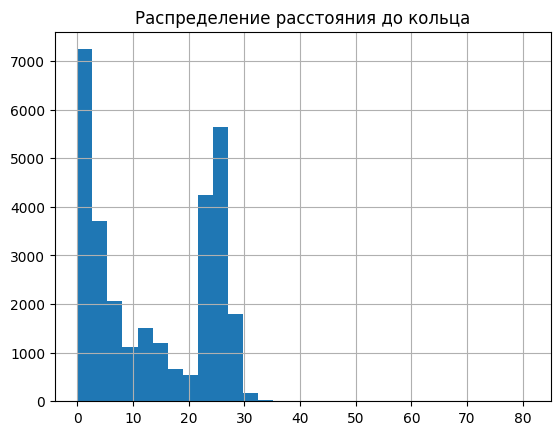

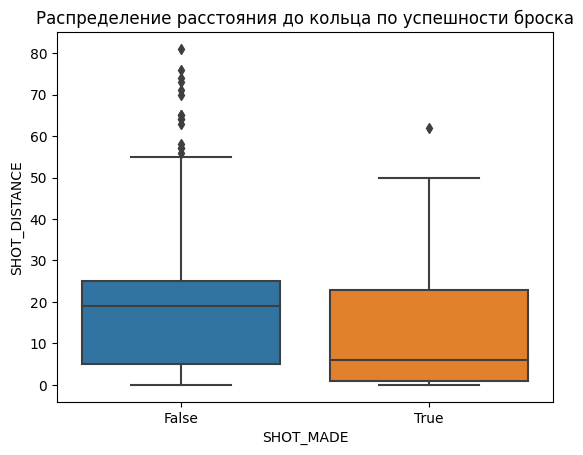

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Гистограмма
data['SHOT_DISTANCE'].hist(bins=30)
plt.title('Распределение расстояния до кольца')
plt.show()

# Боксплот
sns.boxplot(x='SHOT_MADE', y='SHOT_DISTANCE', data=data)
plt.title('Распределение расстояния до кольца по успешности броска')
plt.show()

Корреляционная матрица

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


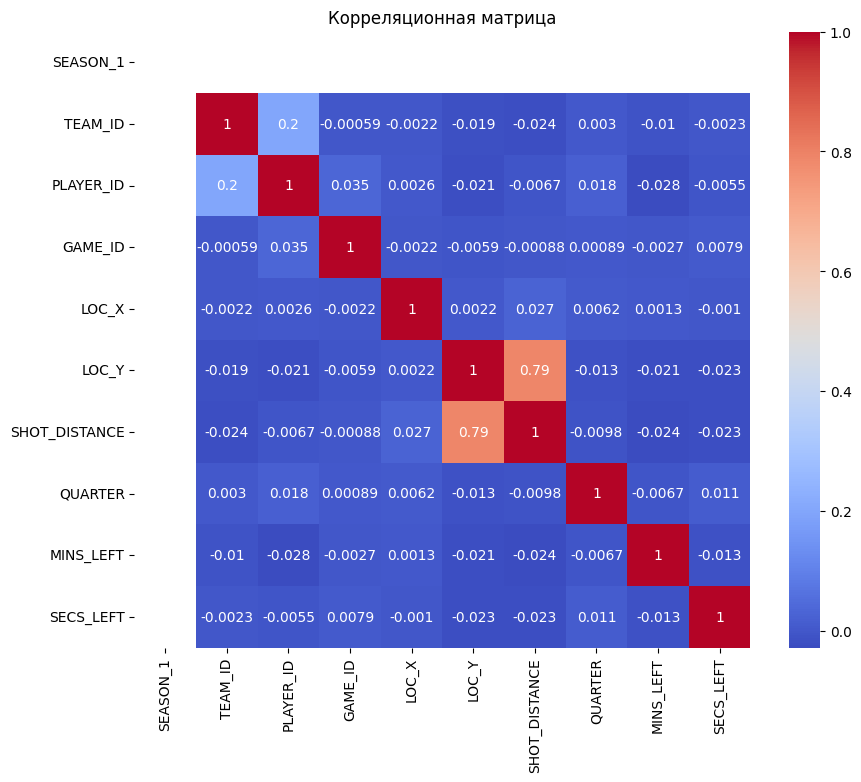

In [9]:
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns

correlation_matrix = data[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Корреляционная матрица')
plt.show()

SHOT_MADE
False    15768
True     14232
Name: count, dtype: int64


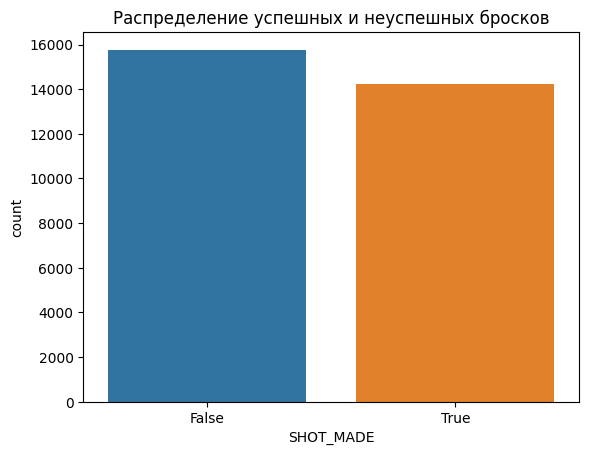

In [10]:
print(data['SHOT_MADE'].value_counts())
sns.countplot(x='SHOT_MADE', data=data)
plt.title('Распределение успешных и неуспешных бросков')
plt.show()

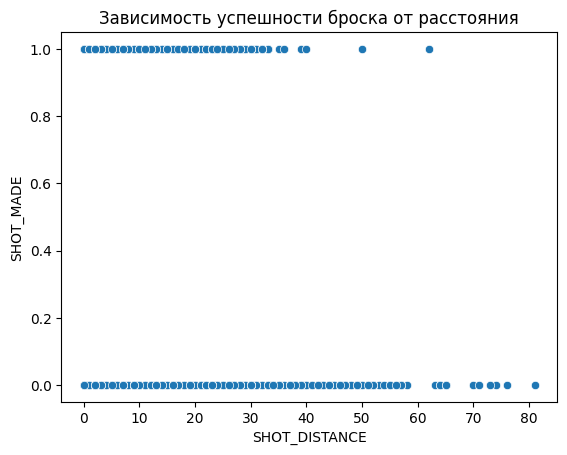

In [11]:
sns.scatterplot(x='SHOT_DISTANCE', y='SHOT_MADE', data=data)
plt.title('Зависимость успешности броска от расстояния')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

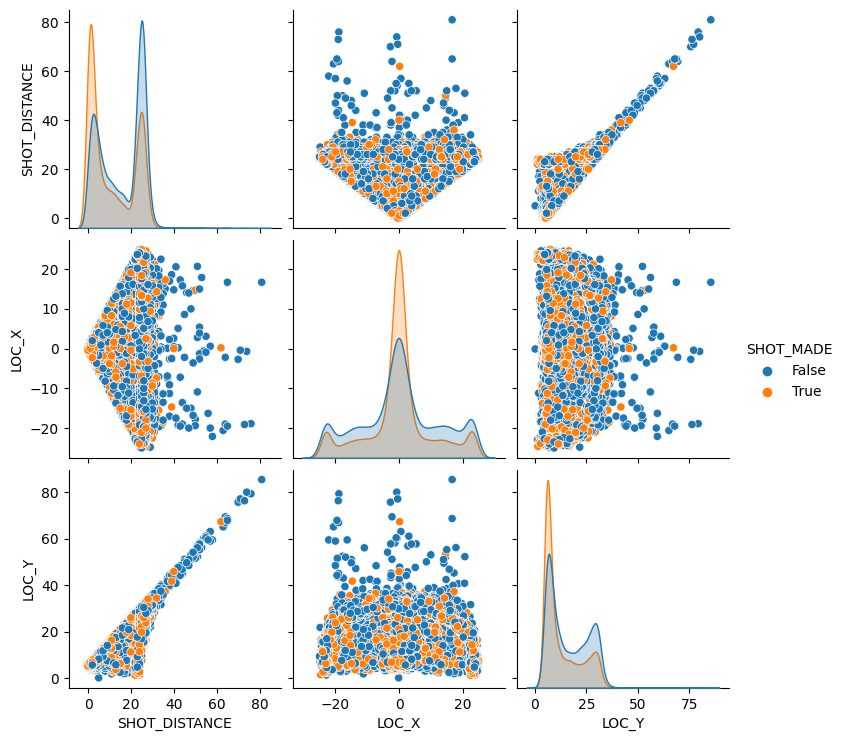

In [12]:
sns.pairplot(data[['SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'SHOT_MADE']], hue='SHOT_MADE')
plt.show()

Распределение бросков по координатам

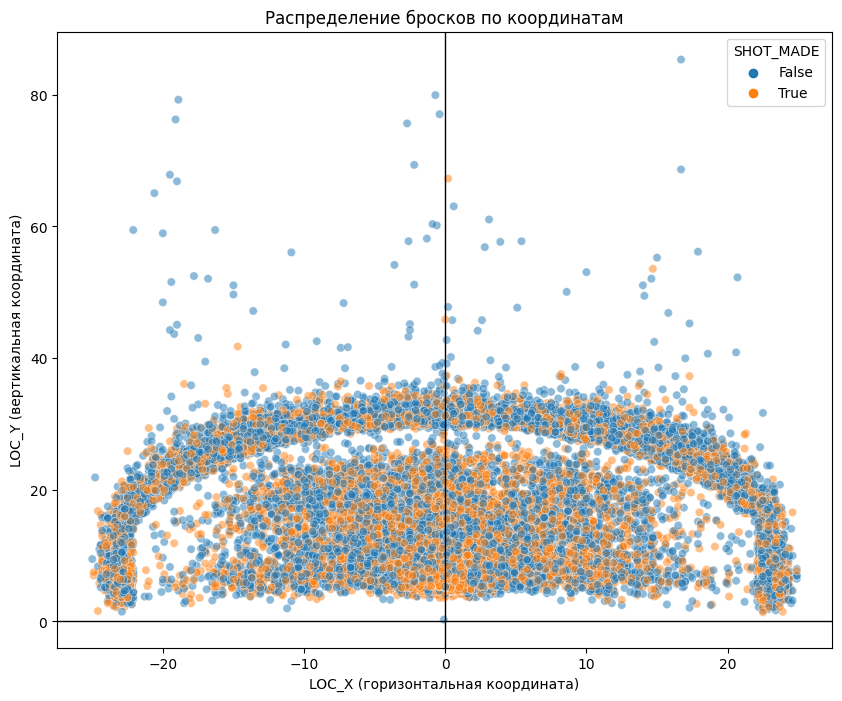

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 8))
sns.scatterplot(x='LOC_X', y='LOC_Y', hue='SHOT_MADE', data=data, alpha=0.5)
plt.title('Распределение бросков по координатам')
plt.xlabel('LOC_X (горизонтальная координата)')
plt.ylabel('LOC_Y (вертикальная координата)')
plt.axhline(0, color='black', linewidth=1) 
plt.axvline(0, color='black', linewidth=1)  
plt.show()

Определение зон броска и Анализ эффективности бросков по зонам

           ZONE  SHOT_MADE
0     Mid-Range   0.438145
1   Three-Point   0.359719
2  Under Basket   0.681017


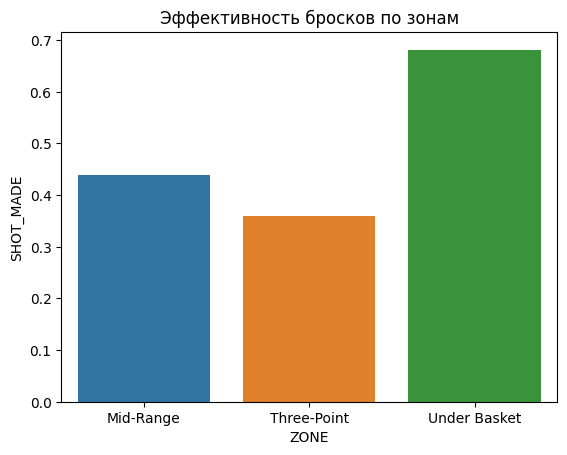

In [14]:
def define_zone(x, y):
    distance = np.sqrt(x**2 + y**2)
    if distance < 8:
        return 'Under Basket'
    elif distance < 24:
        return 'Mid-Range'
    else:
        return 'Three-Point'

data['ZONE'] = data.apply(lambda row: define_zone(row['LOC_X'], row['LOC_Y']), axis=1)

zone_analysis = data.groupby('ZONE')['SHOT_MADE'].mean().reset_index()
print(zone_analysis)

sns.barplot(x='ZONE', y='SHOT_MADE', data=zone_analysis)
plt.title('Эффективность бросков по зонам')
plt.show()

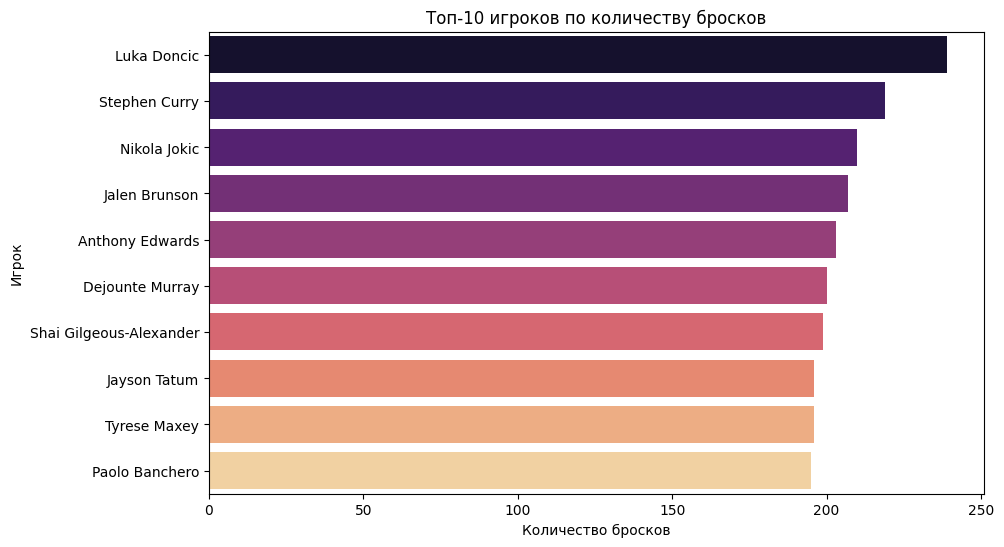

In [15]:
# Группировка данных по игрокам
player_shots = data['PLAYER_NAME'].value_counts().reset_index()
player_shots.columns = ['Player', 'Shots']

# Визуализация (топ-10 игроков)
plt.figure(figsize=(10, 6))
sns.barplot(x='Shots', y='Player', data=player_shots.head(10), palette='magma')
plt.title('Топ-10 игроков по количеству бросков')
plt.xlabel('Количество бросков')
plt.ylabel('Игрок')
plt.show()

Обработка пропущенных значений

In [28]:
missing_values = data.isnull().sum()
print(missing_values)

data_cleaned = data.dropna()
print(f"Размер данных до удаления: {data.shape}")
print(f"Размер данных после удаления: {data_cleaned.shape}")

SEASON_1            0
SEASON_2            0
TEAM_ID             0
TEAM_NAME           0
PLAYER_ID           0
PLAYER_NAME         0
POSITION_GROUP    169
POSITION          169
GAME_DATE           0
GAME_ID             0
HOME_TEAM           0
AWAY_TEAM           0
SHOT_MADE           0
ACTION_TYPE         0
SHOT_TYPE           0
BASIC_ZONE          0
ZONE_NAME           0
ZONE_ABB            0
ZONE_RANGE          0
LOC_X               0
LOC_Y               0
SHOT_DISTANCE       0
QUARTER             0
MINS_LEFT           0
SECS_LEFT           0
ZONE                0
dtype: int64
Размер данных до удаления: (30000, 26)
Размер данных после удаления: (29831, 26)


Преобразует категориальные данные в числовые

In [27]:
categorical_columns = data.select_dtypes(include=['object']).columns
encoded_data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

Нормализация данных

In [18]:
from sklearn.preprocessing import MinMaxScaler

numerical_columns = encoded_data.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
normalized_data = encoded_data.copy()
normalized_data[numerical_columns] = scaler.fit_transform(encoded_data[numerical_columns])

Разделение данных на обучающую и тестовую выборки

In [19]:
from sklearn.model_selection import train_test_split

X = normalized_data.drop('SHOT_MADE', axis=1)
y = normalized_data['SHOT_MADE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Использовали классификатор KNN с параметром n_neighbors=5 для предсказания результата бросков. Результаты показывают, что точность модели составляет примерно 56.2%. Точность модели относительно низкая, что может указывать на сложность задачи или недостаточную информативность признаков.

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.5621666666666667
              precision    recall  f1-score   support

       False       0.58      0.60      0.59      3175
        True       0.54      0.52      0.53      2825

    accuracy                           0.56      6000
   macro avg       0.56      0.56      0.56      6000
weighted avg       0.56      0.56      0.56      6000



Поиск оптимального значения k для классификатора KNN, обучая модель на разных значениях k от 1 до 19 и оценивая точность на тестовой выборке. Результаты показывают, что оптимальное значение k равно 18, при котором точность модели достигает 0.599.

In [21]:
best_k = 1
best_accuracy = 0

for k in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    if accuracy > best_accuracy:
        best_k = k
        best_accuracy = accuracy

print(f"Best k: {best_k}, Best Accuracy: {best_accuracy}")

Best k: 18, Best Accuracy: 0.599


Оптимальное значение k: k=18 дает наилучшую точность среди проверенных значений.
Улучшение точности: По сравнению с исходной точностью 0.562 при k=5, использование k=18 улучшает точность до 0.599.

Обучили модель KNN с оптимальным значением k=18 и оценили ее производительность на обучающей и тестовой выборках.

In [22]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}")

Train Accuracy: 0.656125, Test Accuracy: 0.599


Обучили две дополнительные модели: Random Forest Classifier и Support Vector Machine (SVM), и оценили их точность на тестовой выборке. SVM показала наилучшую точность среди всех моделей, которые использовали (KNN, RF, SVM).

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

rf = RandomForestClassifier(random_state=42)
svm = SVC(random_state=42)

rf.fit(X_train, y_train)
svm.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_pred_svm = svm.predict(X_test)

print(f"RF Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm)}")

RF Accuracy: 0.6128333333333333
SVM Accuracy: 0.6191666666666666


Применение SMOTE для борьбы с несбалансированностью классов. Применение SMOTE привело к небольшому улучшению точности по сравнению с исходной точностью KNN без SMOTE (0.599 при k=18). Однако, в данном случае улучшение незначительное.

In [24]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

knn.fit(X_train_smote, y_train_smote)
y_pred_smote = knn.predict(X_test)
print(accuracy_score(y_test, y_pred_smote))

0.5981666666666666


Исключение коррелированных переменных

In [25]:
import numpy as np
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
X_train_reduced = X_train.drop(to_drop, axis=1)
X_test_reduced = X_test.drop(to_drop, axis=1)

knn.fit(X_train_reduced, y_train)
y_pred_reduced = knn.predict(X_test_reduced)
print(accuracy_score(y_test, y_pred_reduced))

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


0.5893333333333334
